# DAILY

[DAILY HOME PAGE](http://thoth.inrialpes.fr/daly/index.php)

## 数据初探

In [1]:
cd /home/alvin/opt/git/cv/daly

/opt/git/cv/daly


In [16]:
import pickle
import numpy as np
import os
import os.path
import ffmpeg
import cv2
import matplotlib.pyplot as plt

In [19]:
root = "/home/alvin/opt/git/cv/daly/"

daly_data_path = os.path.join(root, "data")

daly_data_annot_pkl = os.path.join(daly_data_path, "official", "daly1.1.0.pkl")

daly_data_video_ids_path = os.path.join(daly_data_path, "video_ids.txt")

In [20]:
# 读取daly数据标注信息
# 该函数已经放入dataset.utils模块中
def read_daly(daly_data_annot_pkl):
    with open(daly_data_annot_pkl, "rb") as f:
        daly = pickle.load(f, encoding='latin1')
    return daly

In [29]:
# 读取daly数据视频id
# 该函数已经放入dataset.utils模块中
def read_daly_ids(video_ids_path):
    with open(video_ids_path) as f:
        ids = f.read()
    ids = ids.split()
    return ids

In [75]:
def get_annots_by_id(daly, v_id):
    suggested_class = daly["annot"][Id+".mp4"]["suggestedClass"]
    return daly["annot"][v_id+".mp4"]["annot"][suggested_class]

In [71]:
def get_keyframes(annot):
    return annot["keyframes"]

In [77]:
def extract_frames(v_path, width, height, frames):
    read_process = (
        ffmpeg
        .input(in_filename)
        .output('pipe:', format='rawvideo', pix_fmt='rgb24')
        .run_async(pipe_stdout=True)
    )
    
    frame_num = 0
    while True:
        in_bytes = read_process.stdout.read(width * height * 3)
        if not in_bytes:
            break
        in_frame = (
            np
            .frombuffer(in_bytes, np.uint8)
            .reshape([height, width, 3])
        )
        if frame_num in frames:
            extract_frame(in_frame, frame_num)
        frame_num += 1
        
    read_process.wait()

In [63]:
daly = read_daly(daly_data_annot_pkl)

In [64]:
video_ids = read_daly_ids(daly_data_video_ids_path)

In [66]:
annots = get_annots_by_id(daly, video_ids[0])

In [73]:
frames = get_keyframes(annots[0])

In [74]:
frames[0]

{'boundingBox': array([[0.35729167, 0.15694444, 0.48854166, 0.58194447]], dtype=float32),
 'objects': array([[ 0.253125  ,  0.33888888,  0.37395832,  0.58194447, 19.        ,
          0.        ,  0.        ]], dtype=float32),
 'frameNumber': 2882,
 'pose': array([[0.39270833, 0.15972222, 0.44166666, 0.22638889, 1.        ,
         0.        , 0.        ],
        [0.39791667, 0.25      , 0.39791667, 0.25      , 1.        ,
         0.        , 0.        ],
        [0.375     , 0.30694443, 0.375     , 0.30694443, 1.        ,
         0.        , 0.        ],
        [0.371875  , 0.34444445, 0.371875  , 0.34444445, 1.        ,
         0.        , 0.        ],
        [0.45833334, 0.23888889, 0.45833334, 0.23888889, 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ]], dtype=float32),
 'ti

In [70]:
annots[0].keys()

dict_keys(['endTime', 'flags', 'beginTime', 'keyframes'])

In [33]:
daly.keys()

dict_keys(['splits', 'joints', 'labels', 'annot', 'version', 'objectList', 'metadata'])

In [54]:
daly["annot"][video_ids[0]+".mp4"].keys()

dict_keys(['suggestedClass', 'annot'])

In [42]:
suggested_class = daly["annot"][video_ids[0]+".mp4"]["suggestedClass"]

In [46]:
annots = daly["annot"][video_ids[0]+".mp4"]["annot"][suggested_class]

In [47]:
len(annots)

14

In [51]:
len(annots[0]["keyframes"])

5

In [52]:
annots[0]["keyframes"][0]

{'boundingBox': array([[0.35729167, 0.15694444, 0.48854166, 0.58194447]], dtype=float32),
 'objects': array([[ 0.253125  ,  0.33888888,  0.37395832,  0.58194447, 19.        ,
          0.        ,  0.        ]], dtype=float32),
 'frameNumber': 2882,
 'pose': array([[0.39270833, 0.15972222, 0.44166666, 0.22638889, 1.        ,
         0.        , 0.        ],
        [0.39791667, 0.25      , 0.39791667, 0.25      , 1.        ,
         0.        , 0.        ],
        [0.375     , 0.30694443, 0.375     , 0.30694443, 1.        ,
         0.        , 0.        ],
        [0.371875  , 0.34444445, 0.371875  , 0.34444445, 1.        ,
         0.        , 0.        ],
        [0.45833334, 0.23888889, 0.45833334, 0.23888889, 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ]], dtype=float32),
 'ti

In [114]:
# %load /home/alvin/opt/git/cv/daly/dataset/daly.py

import pickle
import numpy as np
import os
import os.path
import ffmpeg
import cv2
import tqdm
import random


def show_image(im, figsize=[10, 10]):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(im)
    fig.show()
    

class color_generator(object):
    def __init__(self, base_color = (255, 255, 255), random = False, step = 124):
        self.base = list(base_color)
        self.random = random
        self.step = step
        self.count = 0
    
    def __len__(self):
        return len(self.base)
    
    def __getitem__(self, idx):
        return self.base[idx]
    
    def __setitem__(self, idx, val):
        self.base[idx] = val
    
    def __repr__(self):
        return str(self.base)
    
    def __str__(self):
        return self.__repr__()
    
    def __call__(self):
        while True:
            if self.random is not True:
                yield tuple(self.base)
                color_channel = self.count % 3
                self[color_channel] -= self.step
                if self[color_channel] > 255:
                    self[color_channel] = 0
                elif self[color_channel] < 0:
                    self[color_channel] = 255

                self.count += 1
            yield (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

class DALY(object):
    _pose_color = [(255, 0, 0), (125, 125, 0), (125, 0, 255),
                   (0, 125, 0), (0, 255, 125), (125, 255, 125), (255, 255, 0)]
    def __init__(self, data_root):
        self.root = data_root
        self.daly_root = daly_root = os.path.join(data_root, "daly")
        
        self._annot_pkl = os.path.join(daly_root, "daly1.1.0.pkl")
        self._video_ids_path = os.path.join(daly_root, "video_ids.txt")
        
        self.daly = self._read_daly(self._annot_pkl)
        self.ids = self._read_daly_ids(self._video_ids_path)
        self._mk_out_dir()
        
    def _mk_out_dir(self):
        outroot = os.path.join(self.root, "extracts")
        self.outdir = outdir = os.path.join(outroot, "images")
        self.label_outdir = label_outdir = os.path.join(outroot, "labels")
        self.poly_outdir = poly_outdir = os.path.join(outroot, "polies")
        self._index_file = os.path.join(outroot, "index.txt")
        for label in self.daly["labels"]:
            label_dir = os.path.join(outdir, label)
            if os.path.exists(label_dir) is not True:
                os.makedirs(label_dir)
            label_dir = os.path.join(label_outdir, label)
            if os.path.exists(label_dir) is not True:
                os.makedirs(label_dir)
            label_dir = os.path.join(poly_outdir, label)
            if os.path.exists(label_dir) is not True:
                os.makedirs(label_dir)
                
        
    def _read_daly(self, daly_data_annot_pkl):
        with open(daly_data_annot_pkl, "rb") as f:
            daly = pickle.load(f, encoding='latin1')
        return daly
    
    def _write_pkl(self, pkl_file, data):
        with open(pkl_file, "wb+") as f:
            pickle.dump(data, f)
            
    def _write_index(self, index_file, image_path, label_path):
        with open(index_file, "a+") as f:
            f.write(" ".join([image_path, label_path, "\n"]))
    
    def _read_daly_ids(self, video_ids_path):
        with open(video_ids_path) as f:
            ids = f.read()
        ids = ids.split()
        return ids
    
    def _get_annots_by_id(self, v_id):
        suggested_class = self._suggested_class(v_id)
        return self.daly["annot"][v_id+".mp4"]["annot"][suggested_class]
    
    def _suggested_class(self, v_id):
        return self.daly["annot"][v_id+".mp4"]["suggestedClass"]
    
    def _get_keyframes(self, annot):
        return annot["keyframes"]
    
    def _get_video_fps(self, v_id):
        return self["metadata"][v_id + ".mp4"]["fps"]
    
    def _get_video_scale(self, v_file):
        probe = ffmpeg.probe(v_file)
        video_stream = next((stream for stream in probe['streams'] 
                             if stream['codec_type'] == 'video'), None)
        return (int(video_stream['width']), int(video_stream['height']))
    
    def _get_frames(self, v_id, frame_nums):
        frames = []
        v_file = os.path.join(self.daly_root, "videos", v_id + ".mp4")
        width , height = self._get_video_scale(v_file)
        read_process = (
            ffmpeg
            .input(v_file, r=self._get_video_fps(v_id))
            .output('pipe:', format='rawvideo', pix_fmt='rgb24', r=self._get_video_fps(v_id))
            .run_async(pipe_stdout=True)
        )
        
        frame_num = 0
        while True:
            in_bytes = read_process.stdout.read(width * height * 3)
            if not in_bytes:
                break
            frame = (
                np
                .frombuffer(in_bytes, np.uint8)
                .reshape([height, width, 3])
            )
            
            if frame_num in frame_nums:
                frames.append((frame_num, frame))
            frame_num += 1

        read_process.wait()
        return frames
        
    
    def extract_all_keyframes(self):
        for v_id in tqdm.tqdm(self.ids):
            self.extract_video_keyframes(v_id)
    
    def extract_video_keyframes(self, v_id):
        annots = self._get_annots_by_id(v_id)
        frames = []
        for annot in annots:
            frames.extend(self._get_keyframes(annot))
            
        v_frames = self._get_frames(v_id, [frame["frameNumber"] for frame in frames])
        
        for i, (frame_num, frame) in enumerate(v_frames):
            if frames[i]["frameNumber"] == frame_num:
                image_name = v_id + "_" + str(frame_num)
                frames[i]["filename"] = image_name
                img_path = os.path.join(self.outdir, self._suggested_class(v_id), image_name  + ".jpg")
                pkl_path = os.path.join(self.label_outdir, self._suggested_class(v_id), image_name + ".pkl")
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                cv2.imwrite(img_path, frame)
                self._write_pkl(pkl_path, frames[i])
                self._write_index(self._index_file, img_path, pkl_path)
                
    def __getitem__(self, idx):
        return self.daly[idx]
    
    def read_annot(self, annot_pkl):
        with open(annot_pkl, "rb") as f:
            annot = pickle.load(f)
        return annot
    
    def read_indexes(self):
        with open(self._index_file) as f:
            lines = f.readlines()
        self._indexes = indexes = [line.split() for line in lines]
        
        return indexes
    
    def make_poly(self, record):
        image_path, annot = record
        color = color_generator(random=True)()
        annot = self.read_annot(annot)
        im = cv2.imread(image_path, cv2.IMREAD_COLOR)
        # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        h,w = im.shape[0:2]

        for box in annot["boundingBox"]:
            xmin, ymin, xmax, ymax = (box * np.array([w, h, w, h])).astype(np.int)
            cv2.rectangle(im, (xmin, ymin), (xmax, ymax), next(color), 3)
            cv2.putText(im, 
                        self["annot"]["_".join(annot["filename"].split('_')[:-1]) + ".mp4"]["suggestedClass"],
                       (xmin+5, ymin+5), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,0), 3)

        for obj in annot["objects"]:
            xmin, ymin, xmax, ymax = (obj[0:4] * np.array([w, h, w, h])).astype(np.int)
            cv2.rectangle(im, (xmin, ymin), (xmax, ymax), (next(color)), 3)
            cv2.putText(im, 
                        self["objectList"][int(obj[4])],
                       (xmin+5, ymin+5), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,0), 3)


        head = annot["pose"][0]

        isVisible, isOccluded, isHallucinate = head[-3:].astype(np.bool)

        if isVisible:
            xmin, ymin, xmax, ymax = (head[0:4] * np.array([w, h, w, h])).astype(np.int)
            cv2.rectangle(im, (xmin, ymin), (xmax, ymax), DALY._pose_color[0], 3)
            cv2.putText(im, 
                        "Head",
                       (xmax-10, ymax-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,0), 3)

        for i, point in enumerate(annot["pose"][1:]):
            isVisible, isOccluded, isHallucinate = point[-3:].astype(np.bool)

            if isVisible:
                xmin, ymin, xmax, ymax = (point[0:4] * np.array([w, h, w, h])).astype(np.int)
                cv2.circle(im, (xmin, ymin), 10, DALY._pose_color[i+1], -1)

        return im
    
    def ploy_index(self, idx):
        return self.make_poly(self._indexes[idx])
    
    def ploy_all(self):
        indexes = self.read_indexes()
        for index in tqdm.tqdm(indexes):
            im = self.make_poly(index)
            cv2.imwrite(os.path.join(self.poly_outdir, self["annot"]["_".join(self.read_annot(index[-1])["filename"].split('_')[:-1]) + ".mp4"]["suggestedClass"], self.read_annot(index[-1])["filename"] + ".jpg"), im)


In [115]:
root = "/home/alvin/opt/git/cv/daly/"

daly_data_path = os.path.join(root, "data")


dly = DALY(daly_data_path)

In [116]:
# dly.extract_all_keyframes()

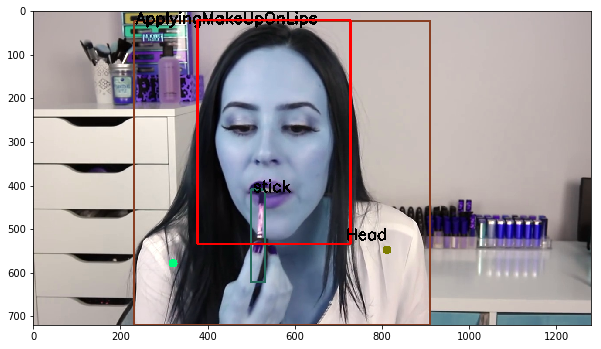

In [117]:
_ = dly.read_indexes()

show_image(dly.ploy_index(0))

In [118]:
dly.ploy_all()

100%|██████████| 9228/9228 [01:33<00:00, 98.41it/s] 


(255, 255, 255)
(131, 255, 255)
(131, 131, 255)
(131, 131, 131)


In [139]:
dly["metadata"]

{'K6xXngYnVK8.mp4': {'duration': 315.25, 'nbframes_ffmpeg': 7566, 'fps': 24.0},
 'legp5cXwuHc.mp4': {'duration': 169.48, 'nbframes_ffmpeg': 4237, 'fps': 25.0},
 'OqmmGZS061o.mp4': {'duration': 168.43333333333334,
  'nbframes_ffmpeg': 5053,
  'fps': 30.0},
 'vEGEMyXpDiE.mp4': {'duration': 61.9, 'nbframes_ffmpeg': 1857, 'fps': 30.0},
 'OJG0TezzLU0.mp4': {'duration': 74.4173,
  'nbframes_ffmpeg': 2217,
  'fps': 29.791459781529294},
 'knGaK70mKH8.mp4': {'duration': 117.92, 'nbframes_ffmpeg': 2948, 'fps': 25.0},
 'osIBbQM7OXw.mp4': {'duration': 176.91006666666667,
  'nbframes_ffmpeg': 5302,
  'fps': 29.97002997002997},
 'pxH_4BCEVCw.mp4': {'duration': 330.01831111111113,
  'nbframes_ffmpeg': 7912,
  'fps': 23.97442727757059},
 'nXHLVkb1U8A.mp4': {'duration': 530.9304,
  'nbframes_ffmpeg': 15912,
  'fps': 29.97002997002997},
 'ftpck5xPlyk.mp4': {'duration': 168.88, 'nbframes_ffmpeg': 4222, 'fps': 25.0},
 'vAOi4HaPxlY.mp4': {'duration': 153.46666666666667,
  'nbframes_ffmpeg': 4604,
  'fps': 

## 数据显示

In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [46]:
root = "/home/alvin/opt/git/cv/daly/"

image_root = os.path.join(root, "data", "extracts")

index_file = os.path.join(image_root, "index.txt")

In [47]:
def read_annot(annot_pkl):
    with open(annot_pkl, "rb") as f:
        annot = pickle.load(f)
    return annot

In [48]:
def read_index(file):
    with open(file) as f:
        lines = f.readlines()
    records = [line.split() for line in lines]
    return records

In [49]:
records = read_index(index_file)

In [50]:
records[100]

['data/extracts/images/ApplyingMakeUpOnLips/6FsbUfGp_3o_665.jpg',
 'data/extracts/labels/ApplyingMakeUpOnLips/6FsbUfGp_3o_665.pkl']

In [53]:
import random

class color_generator(object):
    def __init__(self, base_color = (255, 255, 255), random = False, step = 124):
        self.base = list(base_color)
        self.random = random
        self.step = step
        self.count = 0
    
    def __len__(self):
        return len(self.base)
    
    def __getitem__(self, idx):
        return self.base[idx]
    
    def __setitem__(self, idx, val):
        self.base[idx] = val
    
    def __repr__(self):
        return str(self.base)
    
    def __str__(self):
        return self.__repr__()
    
    def __call__(self):
        color_channel = self.count % 3
        self[color_channel] -= self.step
        if self[color_channel] > 255:
            self[color_channel] = 0
        elif self[color_channel] < 0:
            self[color_channel] = 255
            
        self.count += 1
            
        return tuple(self.base)


def make_poly(record):
    image_path, annot = record
    color = color_generator()
    annot = read_annot(os.path.join(root, annot))
    im = cv2.imread(os.path.join(root, image_path), cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    h,w = im.shape[0:2]
    
    print(annot)
    
    for box in annot["boundingBox"]:
        xmin, ymin, xmax, ymax = (box * np.array([w, h, w, h])).astype(np.int)
        cv2.rectangle(im, (xmin, ymin), (xmax, ymax), color(), 3)
        
    for obj in annot["objects"]:
        xmin, ymin, xmax, ymax = (obj[0:4] * np.array([w, h, w, h])).astype(np.int)
        cv2.rectangle(im, (xmin, ymin), (xmax, ymax), color(), 3)
    
    
    head = annot["pose"][0]
    
    isVisible, isOccluded, isHallucinate = head[-3:].astype(np.bool)

    if isVisible:
        xmin, ymin, xmax, ymax = (head[0:4] * np.array([w, h, w, h])).astype(np.int)
        cv2.rectangle(im, (xmin, ymin), (xmax, ymax), color(), 3)
        
    for point in annot["pose"][1:]:
        isVisible, isOccluded, isHallucinate = point[-3:].astype(np.bool)
    
        if isVisible:
            xmin, ymin, xmax, ymax = (point[0:4] * np.array([w, h, w, h])).astype(np.int)
            cv2.circle(im, (xmin, ymin), 10, color(), -1)
        
    return im

{'boundingBox': array([[0.001    , 0.3428064, 0.65     , 0.9928952]], dtype=float32), 'objects': array([[ 0.385    ,  0.7531083,  0.623    ,  0.9218472, 32.       ,
         0.       ,  0.       ]], dtype=float32), 'frameNumber': 3129, 'pose': array([[0.        , 0.3516874 , 0.055     , 0.74245113, 1.        ,
        1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.218     , 0.8348135 , 0.218     , 0.8348135 , 1.        ,
        0.        , 0.        ],
       [0.604     , 0.9840142 , 0.604     , 0.9840142 , 1.        ,
        1.        , 1.        ],
       [0.54      , 0.8348135 , 0.54      , 0.8348135 , 1.        ,
        0.        , 0.        ]], dtype=float32), 'time': 104.39, 'filename': 'Hha

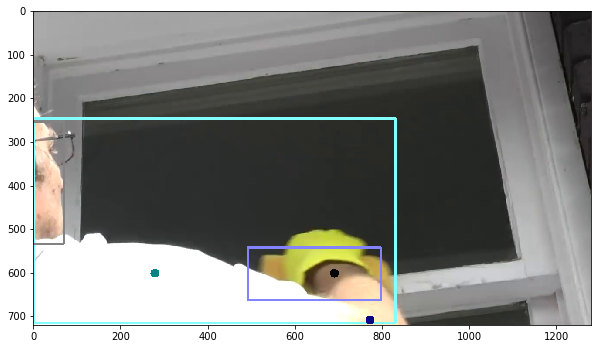

In [54]:
def show_image(im, figsize=[10, 10]):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(im)
    fig.show()

show_image(make_poly(records[1952]))